Import libraries 

In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Input, Dropout, Activation, Dense, BatchNormalization
from keras.layers.pooling import MaxPool2D
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Create variables

In [3]:
IMG_SIZE=(128,128)
char_path=r'./characters'
characters = {}
images = []
labels = []

In [4]:
num = 0

for name in os.listdir(char_path):
    characters[name] = num
    num += 1

for character in characters:
    print(characters[character], ' ', character)

0   abraham_grampa_simpson
1   agnes_skinner
2   apu_nahasapeemapetilon
3   barney_gumble
4   bart_simpson
5   carl_carlson
6   charles_montgomery_burns
7   chief_wiggum
8   cletus_spuckler
9   comic_book_guy
10   disco_stu
11   edna_krabappel
12   fat_tony
13   gil
14   groundskeeper_willie
15   homer_simpson
16   kent_brockman
17   krusty_the_clown
18   lenny_leonard
19   lionel_hutz
20   lisa_simpson
21   maggie_simpson
22   marge_simpson
23   martin_prince
24   mayor_quimby
25   milhouse_van_houten
26   miss_hoover
27   moe_szyslak
28   ned_flanders
29   nelson_muntz
30   otto_mann
31   patty_bouvier
32   principal_skinner
33   professor_john_frink
34   rainier_wolfcastle
35   ralph_wiggum
36   selma_bouvier
37   sideshow_bob
38   sideshow_mel
39   snake_jailbird
40   troy_mcclure
41   waylon_smithers


Create dataset

In [5]:
def process_image(image):
    
    image = cv2.resize(image, IMG_SIZE)

    return np.array(image)/ 255.0
    

In [6]:
def process_class(label_str):
    
    label = []
    for i in range(len(characters)):
        label.append(0.0)
            
    label[characters[label_str]] = 1.0
    np.array(label)
    return label

In [7]:
def generate_images(image, x1, y1, x2, y2):
    generated_images = [image]
    
    if x2 > x1 and y2 > y1:
        generated_images.append(image[y1:y2, x1:x2])
        
    generated_images.append(cv2.flip(image, 1))
    
    generated_images.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
    
    generated_images.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    
    contrast = 1.5
    generated_images.append(cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, 0))
    
    return generated_images

In [8]:
with open("annotations.txt") as file:
    for line in file:
        path, X1, Y1, X2, Y2, class_name = line.split(",")
        X1 = int(X1)
        Y1 = int(Y1)
        X2 = int(X2)
        Y2 = int(Y2)
        cleaned_name = class_name.rstrip()
        
        extended_images = generate_images(cv2.imread(path) , X1, Y1, X2, Y2)
        
        processed_class = process_class(cleaned_name)
        
        for elem in extended_images:
            im = process_image(elem)
            images.append(im)
            labels.append(processed_class)
            

In [9]:
images = np.array(images)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=95)

In [10]:
del images
del labels
print(X_train.shape)
print(y_test.shape)

(34396, 128, 128, 3)
(6071, 42)


In [11]:
def get_name(class_marks):
    
    i = 0
    for mark in class_marks:
        if mark == 1.0:
            break
        else: i = i + 1
    
    for character in characters:
        if characters[character] == i:
            return character
    return ' '

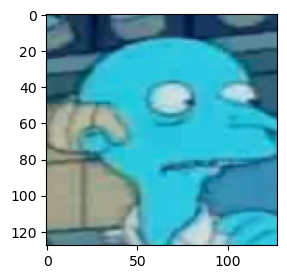

charles_montgomery_burns


In [12]:
img = tf.keras.preprocessing.image.array_to_img(X_train[103])
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.show()
print(get_name(y_train[103]))

Create Model

In [13]:
model = tf.keras.models.Sequential([
    
    Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(256, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(512, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(1024, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    BatchNormalization(),

    Flatten(),
    Dropout(0.2),

    Dense(1024, kernel_constraint=maxnorm(3)),
    Activation('relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, kernel_constraint=maxnorm(3)),
    Activation('relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, kernel_constraint=maxnorm(3)),
    Activation('relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, kernel_constraint=maxnorm(3)),
    Activation('relu'),
    Dropout(0.2),
    BatchNormalization(),

    Dense(y_test.shape[1]),
    Activation('softmax'),
])


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.build()

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)       0

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_test, y_test), 
    batch_size=32,
)

Epoch 1/25
1075/1075 [==============================] - 39s 36ms/step - loss: 2.8361 - accuracy: 0.0920 - val_loss: 2.7727 - val_accuracy: 0.0883
Epoch 2/25
1075/1075 [==============================] - 37s 35ms/step - loss: 2.7752 - accuracy: 0.0908 - val_loss: 2.7708 - val_accuracy: 0.1029
Epoch 3/25
1075/1075 [==============================] - 37s 34ms/step - loss: 2.7751 - accuracy: 0.0903 - val_loss: 2.7710 - val_accuracy: 0.1029
Epoch 4/25
1075/1075 [==============================] - 37s 34ms/step - loss: 2.7751 - accuracy: 0.0889 - val_loss: 2.7697 - val_accuracy: 0.1029
Epoch 5/25
1075/1075 [==============================] - 38s 35ms/step - loss: 2.7746 - accuracy: 0.0893 - val_loss: 2.7698 - val_accuracy: 0.0858
Epoch 6/25
1075/1075 [==============================] - 38s 36ms/step - loss: 2.7737 - accuracy: 0.0924 - val_loss: 2.7702 - val_accuracy: 0.0883
Epoch 7/25
1075/1075 [==============================] - 37s 35ms/step - loss: 2.7734 - accuracy: 0.0907 - val_loss: 2.7685 -

In [15]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 10.29%


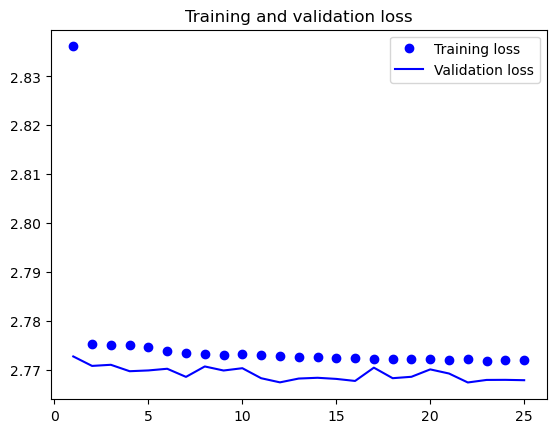

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
model.save('my_model.h5')

In [18]:
#new_model = tf.keras.models.load_model('my_model.h5')